# Cognitive Data with Catboost
https://catboost.ai/

See **[CatBoost regression in 6 minutes](https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329)** for brief overview.

Note: In order to use `SHAP`, the notebook needs be run under python 3.10.  
To do this:
- create a virtual environment using python3.10: `python3.10 -m venv venv`  
- activate the environment: `source venv/bin/activate`
- install the requirements: `pip install -r requirements.txt -U`
- run `jupyter` from enviroment: `./venv/bin/jupyter lab`

See also the NHANES example using SHAP: https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html

In [4]:
import pandas as pds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import r2_score, mean_squared_error
from IPython.display import display
import shap

In [5]:
%matplotlib inline 
sns.set() # set seaborn styles, not sure I need to run %matplotlib inline 

## helper functions

### feature_imp

In [6]:
def feature_imp(df,model):
    fi = pds.DataFrame()
    fi["feature"] = df.columns
    fi["importance"] = model.feature_importances_
    return fi.sort_values(by="importance", ascending=False)

---

## data prep
create datafarames for deomgraphics, cognitive functioning scrores, and perio info  
NHANES cognitive data downloaded from https://www.icpsr.umich.edu/web/about/cms/3625/

In [7]:
demo_df = pds.read_table('../refined_data/demographics.tsv',  index_col='SEQN')
nhanescog_df = pds.read_csv('../data/nhanescog_2011_12_CSV.csv', index_col='seqn')
nhanescog_df.index.name = 'SEQN' # change index name for merging
perio_df = pds.read_table('../refined_data/perio_summary.tsv', index_col='SEQN')

merge dataframes together

In [8]:
# merge demographics, cognitive functioning scores, and perio
merged_df = \
    demo_df.merge(
        nhanescog_df.merge(perio_df, how='inner', on='SEQN'),
        how='inner',
        on='SEQN'
    )
len(merged_df)

837

In [9]:
merged_df.head()

,RIDAGEYR,RIAGENDR,RIDRETH1,RIDRETH3,DMDMARTL,year,ridstatr,riagendr,female,ridageyr,...,num_teeth,max_CAL,num_teeth_gt_3,num_teeth_gt_4,num_teeth_gt_5,num_teeth_gt_6,pct_teeth_gt_3,pct_teeth_gt_4,pct_teeth_gt_5,pct_teeth_gt_6
SEQN,,,,,,,,,,,,,,,,,,,,,
62164,44,2,3,3,1.0,2011-2012,2,2,1,44,...,27.0,3.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00
62172,43,2,4,4,5.0,2011-2012,2,2,1,43,...,18.0,5.0,3.0,1.0,0.0,0.0,0.17,0.06,0.00,0.00
62174,80,1,3,3,1.0,2011-2012,2,1,0,80,...,27.0,5.0,12.0,3.0,0.0,0.0,0.44,0.11,0.00,0.00
62176,34,2,3,3,1.0,2011-2012,2,2,1,34,...,28.0,2.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00
62177,51,1,5,6,1.0,2011-2012,2,1,0,51,...,11.0,12.0,11.0,11.0,10.0,8.0,1.00,1.00,0.91,0.73


---

## split train/test datasets

In [10]:
scores = ['low_global_re', 'low_cerad_re', 'low_animal_re', 'low_digit_re', 'low_delayed_re']

train_df = merged_df.dropna()[['z_global_age', 'pct_teeth_gt_3', 'pct_teeth_gt_4', 'pct_teeth_gt_5', 'pct_teeth_gt_6']]
train_df = train_df.rename(columns={'z_global_age': 'age'})

y = {
    score: merged_df.dropna()[score].values
    for score in scores
}

In [11]:
# standarize train_df values
scaler = StandardScaler()
scaled_df = pds.DataFrame(scaler.fit_transform(train_df.to_numpy()), columns=train_df.columns, index=train_df.index)
scaled_df = pds.merge(merged_df[['female']], scaled_df, how='inner', on='SEQN')

In [13]:
scaled_df.female.value_counts()

0    207
1    106
Name: female, dtype: int64

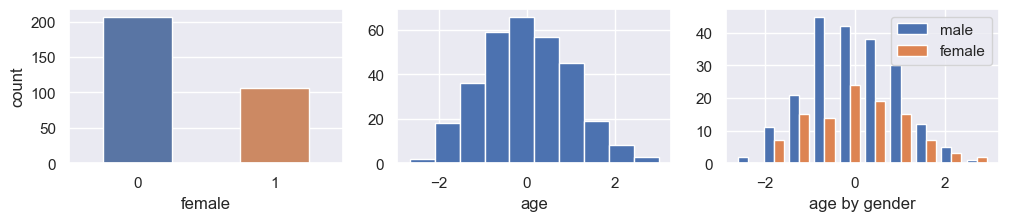

In [14]:
# plt.figure(figsize=(10,2))
fig, axs = plt.subplots(1, 3, figsize=(12,2))

# gender counts
sns.barplot(
    ax=axs[0],
    data=scaled_df.female.value_counts().reset_index().rename(columns={'index': 'female', 'female': 'count'}),
    x='female', 
    y='count',
    width=0.5
)


# total age counts
axs[1].hist(scaled_df[['age']])
axs[1].set_xlabel('age')

# age counts by gender
axs[2].hist(
        [
            scaled_df.loc[scaled_df['female'] == 0, 'age'],
            scaled_df.loc[scaled_df['female'] == 1, 'age']
        ],
        label=['male', 'female']
     )
axs[2].set_xlabel('age by gender')

plt.legend()
# for ax in axs.flat: ax.label_outer() # share y axis
plt.show()

In [15]:
# create test and train datasets
X_train, X_test, y_train, y_test = \
    train_test_split(
        #train_df.pct_teeth_gt_3.values.reshape(-1, 1), 
        scaled_df,
        y['low_global_re'], 
        test_size=0.3, 
        random_state=42, 
        stratify=y['low_global_re']
    )

In [16]:
train_dataset = cb.Pool(X_train, y_train, cat_features=['female'])
test_dataset = cb.Pool(X_test, y_test, cat_features=['female'])

___

## Catboost classifier

In [17]:
# logging_level='Silent' suppresses the output
model = cb.CatBoostClassifier(logging_level='Silent', iterations=1000)

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

# After searching, the model is trained and ready to use.
# verbose=False suppresses the output
params = model.grid_search(grid, train_dataset, train_size=0.7, verbose=False) 
# params = model.grid_search(grid, X=X_train, y=y_train, train_size=0.7, verbose=False) 
# model.fit(train_dataset, eval_set=test_dataset, use_best_model=True)

In [18]:
# params # uncomment to see grid search results

In [19]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[::,1] # regressor doesn't implement predict_proba
# print("Count of trees in model = {}".format(model.tree_count_))

In [20]:
# y_pred

In [23]:
auc_score = round(roc_auc_score(y_test, y_proba), 5)
report = classification_report(y_test, y_pred, zero_division=0)

### plot results

In [24]:
print(f'AUC: {auc_score}')
print(report)

AUC: 0.92917
              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92        70
         1.0       0.78      0.75      0.77        24

    accuracy                           0.88        94
   macro avg       0.85      0.84      0.84        94
weighted avg       0.88      0.88      0.88        94



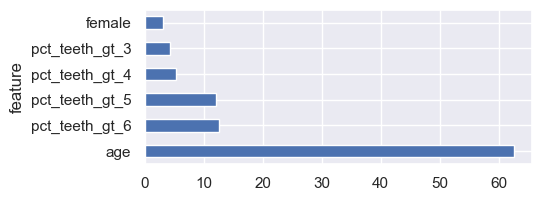

In [25]:
feature_imp(X_train,model).plot('feature', 'importance', 'barh', figsize=(5,2), legend=False)
plt.show()

---

## SHAP values  
https://github.com/slundberg/shap  
https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Catboost%20tutorial.html  
https://towardsdatascience.com/shap-for-categorical-features-with-catboost-8315e14dac1

In [26]:
shap.initjs()

In [36]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(test_dataset)

In [37]:
# shap_values

In [38]:
# visualize the first prediction's explanation
# documentation: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html
# shap.plots.waterfall(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])
# shap.plots.waterfall.waterfall(explainer.expected_value[0])
# shap.plots.waterfall(shap_values[0])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output.  
Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. Another way to visualize the same explanation is to use a force plot.

In [39]:
# visualize the first prediction's explanation with a force plot
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset 

In [40]:
# visualize all the training set predictions
# shap.plots.force(shap_values)
shap.force_plot(explainer.expected_value, shap_values, X_train)

In [41]:
X_train.columns # display column names

Index(['female', 'age', 'pct_teeth_gt_3', 'pct_teeth_gt_4', 'pct_teeth_gt_5',
       'pct_teeth_gt_6'],
      dtype='object')

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in `low_global_re` as `age` changes. 
Vertical dispersion at a single `age` value represents interaction effects with other features. To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument the scatter plot will pick the best feature to color by. In this case, it picks `pct_teeth_gt_4` (percentage of teeth with a CAL > 4mm) since that highlights that `age` has less impact for patients' `pct_teeth_gt_4`.

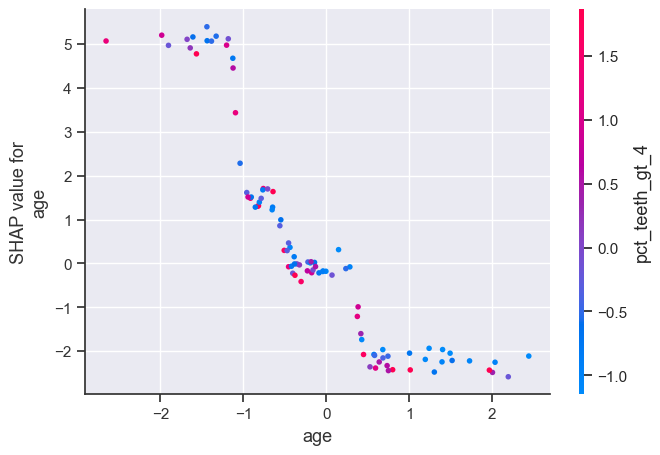

In [43]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
# shap.plots.scatter(shap_values[:,"age"], color=shap_values)
shap.dependence_plot("age", shap_values, X_test)

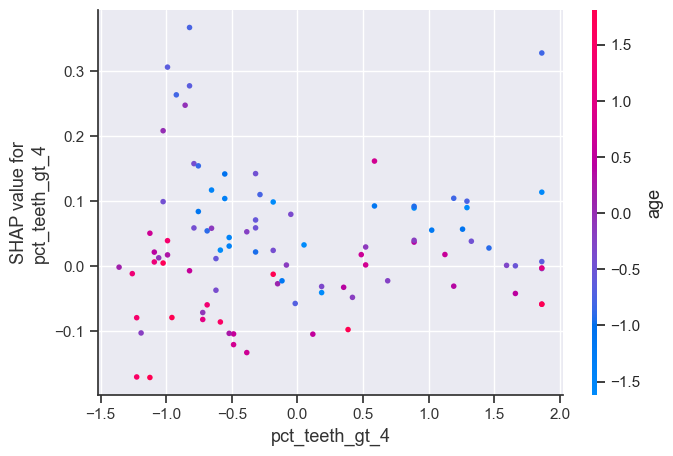

In [45]:
# shap.plots.scatter(shap_values[:,"pct_teeth_gt_4"], color=shap_values)
shap.dependence_plot("pct_teeth_gt_4", shap_values, X_test)

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


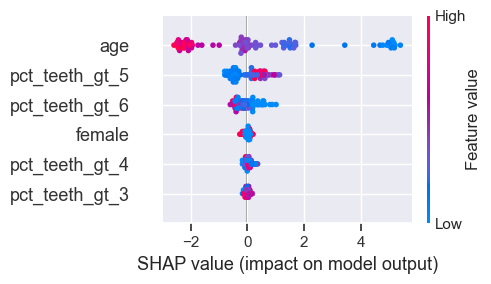

In [46]:
# summarize the effects of all the features
# shap.plots.beeswarm(shap_values, plot_size=(5, 3))
shap.summary_plot(shap_values, X_test,  plot_size=(5, 3))

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs).  
documentation: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html

In [322]:
# shap.plots.bar(shap_values)

In [323]:
# shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

In [324]:
# clustering = shap.utils.hclust(X_train, y_train) 
# shap.plots.bar(shap_values, clustering=clustering)

---

## SHAP Interaction Values
https://github.com/slundberg/shap#shap-interaction-values  

SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented for tree models with shap.TreeExplainer(model).shap_interaction_values(X). This returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. These values often reveal interesting hidden relationships.  
See also the NHANES example using SHAP: https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html

In [233]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features more time than SHAP values to compute
# shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_train)

In [234]:
# shap.summary_plot(shap_interaction_values, X_train)

In [235]:
# shap.dependence_plot(
#     ("age", "pct_teeth_gt_4"),
#     shap_interaction_values, X_train)